# Apprentissage automatique II: Apprentissage profond et ses applications

## Projet 

**Maya Otomo-Lauzon**, **id : 11282915**

**Hichem Sahraoui**, **id : 11257735**

**Idrissa Coulibaly**, **id : 11119684**

**Mustapha Bouhsen**, **id : 11321500**


## Importation des bibliothèques

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.ticker as mtick
import torch
import copy
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset

In [ ]:
# GPU ou CPU ?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Importation et exploration des données 

In [ ]:
import re

pattern = r"(?:\b\w+\b|['\"“”‘’])"
url = re.compile(r'http\S+|www\S+')
ponct = re.compile(r'[^\w\s]')
digit = re.compile(r'\d+')
non_ascii = re.compile(r'[^\x00-\x7F]+')

# Fonction qui nettoie le text 
def text_clean(text):
  text = text.replace("\'", "")
  text = text.replace("\n", "")
  text = text.replace("<br />", "")

  # enlver les site webs
  text = url.sub('', text)
  # enlever ponctuation
  text = ponct.sub('', text)
  # enlever les digits
  text = digit.sub('', text)
  # enlever non-ASCII
  text = non_ascii.sub('', text)

  # enlever les charcteres uniques
  words = [word for word in re.findall(pattern, text) if len(word) > 1]
  text = " ".join(words)
  return text

In [ ]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


## Nettoyage de données

In [ ]:
texts = []

for word in df["text"]:
    x = word.lower()
    texts.append(text_clean(x))
    
df['text'] = texts

texts = []

for word in df_test["text"]:
    x = word.lower()
    texts.append(text_clean(x))
    
df_test['text'] = texts

In [ ]:
df_test

,text,emotion
0,feel incredibly weepy,0
1,feeling contented wife mother,1
2,pick novels feel like dropping luggage signing...,1
3,little extra interest right feeling like husba...,1
4,feel become even lot vital high eighty five we...,1
...,...,...
28278,feel honored motivated share world life changi...,1
28279,feel like gloaty really delighted,1
28280,feel little energetic one day next several day...,1
28281,feel work experience fell although fantastic o...,1


In [ ]:
df.head()

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0


## Distribution des émotion

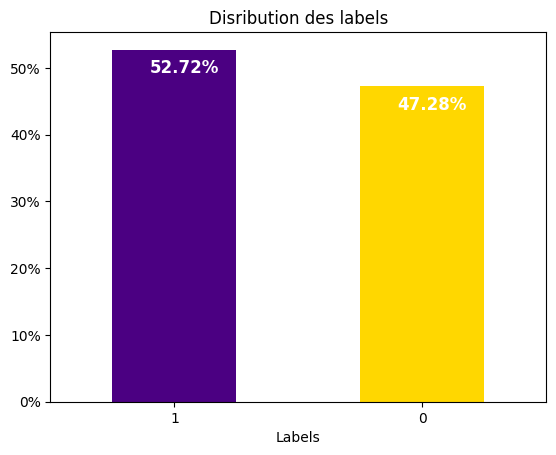

In [ ]:
# Graphique
x = (df['emotion'].value_counts()*100/len(df['emotion'])).plot(kind = 'bar', 
                                                  color = ['indigo', 'gold'], rot=0)
x.yaxis.set_major_formatter(mtick.PercentFormatter())
x.set_xlabel('Labels')
x.set_title('Disribution des labels')

for i in x.patches:
    x.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()), 2))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

D'après le graphique en dessus, les classes semblent équilbrées

# Modèles de base

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(max_features = 20000, stop_words = "english")

X = vec.fit_transform(df["text"])
tf_transformer = TfidfTransformer(use_idf=False)
X = tf_transformer.transform(X)
y = df["emotion"]

X_test = vec.fit_transform(df_test["text"])
tf_transformer = TfidfTransformer(use_idf=False)
X_test = tf_transformer.transform(X_test)
y_test = df_test["emotion"]

## Naive Bayes
 
Le modele est donnees par la fonction suivante. Notre but est trouver les parametres qui maximisent cette dernmiere.

$$
\mathbb{P}(Y=k|X) \propto \mathbb{P}(X|Y=k)  \ \mathbb{P}(Y=k)
$$

Dans notre fonction, nous allons trouver le parametres $\alpha$ optimum pour :

$$
\mathbb{P}(Y=k) = \pi_k = \frac{N_k + \alpha_k}{N + \sum_{k'} \alpha_{k'}}
$$

Ou : 

* $N_k$ : Nombre observation pour k = {0,1}

* N : Nombre d'obeservation total

Nous allons tester notre modele sur $\alpha$ = {0.5, 0.75, 1, 1.25, 1.5, 10}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score

# Validation croisée
alpha = [0.5, 0.75, 1, 1.25, 1.5, 10]

# Séparer le jeu de données en 10  groupes
kf = KFold(n_splits=10,shuffle=True)
i =0


for a in alpha:
    
    model = MultinomialNB(alpha=a)
    j = 0
    
    # vecteurs qui vont contenir les accuracy pour chaque split 
    acc_train = np.zeros(10) 
    acc_valid = np.zeros(10)
    prec_train = np.zeros(10)
    prec_valid = np.zeros(10)
    recall_train = np.zeros(10)
    recall_valid = np.zeros(10)
    f1_train = np.zeros(10)
    f1_valid = np.zeros(10)
    
    for i_train, i_valid in kf.split(X):
        x_temp_train, x_temp_valid = X[i_train], X[i_valid]
        y_temp_train, y_temp_valid = y[i_train], y[i_valid]
        model = model.fit(x_temp_train, y_temp_train)
        pred_train = model.predict(x_temp_train)
        pred_valid = model.predict(x_temp_valid)
        
        acc_train[j] = np.mean(pred_train ==  y_temp_train)
        acc_valid[j] = np.mean(pred_valid == y_temp_valid)
        
        prec_train[j] = precision_score(y_temp_train, pred_train)
        prec_valid[j] = precision_score(y_temp_valid, pred_valid)

        recall_train[j] = recall_score(y_temp_train, pred_train)
        recall_valid[j] = recall_score(y_temp_valid, pred_valid)

        f1_train[j] = f1_score(y_temp_train, pred_train)
        f1_valid[j] = f1_score(y_temp_valid, pred_valid)

        j = j+1

    
    acc_train_f = np.round(np.mean(acc_train)*100, 2)
    acc_valid_f = np.round(np.mean(acc_valid)*100, 2)
    
    prec_train_f = np.round(np.mean(prec_train)*100,2)
    prec_valid_f = np.round(np.mean(prec_valid)*100,2)

    recall_train_f = np.round(np.mean(recall_train)*100,2)
    recall_valid_f = np.round(np.mean(recall_valid)*100,2)

    f1_train_f = np.round(np.mean(f1_train)*100,2)
    f1_valid_f = np.round(np.mean(f1_valid)*100,2)

    print("-----------------------------------")
    print("Alpha = ", alpha[i])
    print("Accuracy train = ",acc_train_f, "% || Accuracy validation =", acc_valid_f,"%")
    print("Precision train = ", prec_train_f, "% || Precision validation =", prec_valid_f,"%")
    print("recall train = ", recall_train_f, "% || Precision validation =", recall_valid_f,"%")
    print("f1 train = ", f1_train_f, "% || Precision validation =", f1_valid_f,"%")

    print("-----------------------------------")
    i += 1

-----------------------------------
Alpha =  0.5
Accuracy train =  94.9 % || Accuracy validation = 94.08 %
Precision train =  94.14 % || Precision validation = 93.2 %
recall train =  96.32 % || Precision validation = 95.74 %
f1 train =  95.21 % || Precision validation = 94.46 %
-----------------------------------
-----------------------------------
Alpha =  0.75
Accuracy train =  94.9 % || Accuracy validation = 94.14 %
Precision train =  94.12 % || Precision validation = 93.27 %
recall train =  96.34 % || Precision validation = 95.8 %
f1 train =  95.22 % || Precision validation = 94.52 %
-----------------------------------
-----------------------------------
Alpha =  1
Accuracy train =  94.89 % || Accuracy validation = 94.19 %
Precision train =  94.09 % || Precision validation = 93.31 %
recall train =  96.37 % || Precision validation = 95.85 %
f1 train =  95.22 % || Precision validation = 94.56 %
-----------------------------------
-----------------------------------
Alpha =  1.25
Accu

## Réseau de neurones (FNN)

On va maintenant entrainer plusieurs réseaux de neurones afin de choisir la meilleur combinaison d'hyperparamètres. On va utiliser les hyperparamètres suivant pour entrainer le modèle :

$$
\lambda \in \{{0.01, 0.1, 1}\}
\\
\alpha \in \{{0.0001, 0.001, 0.01}\}
\\
L \in \{{500, 500, 500}\}
$$

 * $\lambda$ : régularisation
 * $\alpha$ : taux d'apprentissage
 * $L$ : nombre de noeud dans chaque hidden laye

In [ ]:
from sklearn.model_selection import train_test_split

# Prise de 80% des données pour l'entrainement
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 1234)


In [ ]:
from sklearn.neural_network import MLPClassifier

C = [0.01, 0.1,  1]
R = [0.001, 0.01, 0.1]

for i in range(0, len(C)):
    for j in range(0, len(R)):
        nn = MLPClassifier(random_state=1234, early_stopping=True, 
                              hidden_layer_sizes = (500, 500, 500), alpha=C[i], learning_rate_init=R[j])
        nn.fit(X_train, y_train)

        pred_train = nn.predict(X_train)
        pred_valid = nn.predict(X_valid)

        acc_train = np.mean(pred_train ==  y_train)
        acc_valid = np.mean(pred_valid == y_valid)
        
        prec_train = precision_score(y_train, pred_train)
        prec_valid = precision_score(y_valid, pred_valid)

        recall_train = recall_score(y_train, pred_train)
        recall_valid = recall_score(y_valid, pred_valid)

        f1_train = f1_score(y_train, pred_train)
        f1_valid = f1_score(y_valid, pred_valid)

        acc_train_f = np.round((acc_train)*100, 2)
        acc_valid_f = np.round((acc_valid)*100, 2)
    
        prec_train_f = np.round((prec_train)*100,2)
        prec_valid_f = np.round((prec_valid)*100,2)

        recall_train_f = np.round((recall_train)*100,2)
        recall_valid_f = np.round((recall_valid)*100,2)

        f1_train_f = np.round((f1_train)*100,2)
        f1_valid_f = np.round((f1_valid)*100,2)
        print("-----------------------------------")
        print("Lambda = ", C[i])
        print("Alpha = ", R[j])
        print("Accuracy train = ",acc_train_f, "% || Accuracy validation =", acc_valid_f,"%")
        print("Precision train = ", prec_train_f, "% || Precision validation =", prec_valid_f,"%")
        print("recall train = ", recall_train_f, "% || Precision validation =", recall_valid_f,"%")
        print("f1 train = ", f1_train_f, "% || Precision validation =", f1_valid_f,"%")
        print("-----------------------------------")             

-----------------------------------
Lambda =  0.01
Alpha =  0.001
Accuracy train =  96.96 % || Accuracy validation = 95.13 %
Precision train =  97.18 % || Precision validation = 95.46 %
recall train =  97.05 % || Precision validation = 95.32 %
f1 train =  97.11 % || Precision validation = 95.39 %
-----------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-----------------------------------
Lambda =  0.01
Alpha =  0.01
Accuracy train =  96.68 % || Accuracy validation = 94.91 %
Precision train =  96.67 % || Precision validation = 95.01 %
recall train =  97.03 % || Precision validation = 95.38 %
f1 train =  96.85 % || Precision validation = 95.2 %
-----------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-----------------------------------
Lambda =  0.01
Alpha =  0.1
Accuracy train =  93.41 % || Accuracy validation = 93.08 %
Precision train =  93.06 % || Precision validation = 92.75 %
recall train =  94.55 % || Precision validation = 94.29 %
f1 train =  93.8 % || Precision validation = 93.51 %
-----------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-----------------------------------
Lambda =  0.1
Alpha =  0.001
Accuracy train =  95.94 % || Accuracy validation = 95.08 %
Precision train =  96.6 % || Precision validation = 95.91 %
recall train =  95.67 % || Precision validation = 94.73 %
f1 train =  96.13 % || Precision validation = 95.31 %
-----------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


AttributeError: ignored

In [ ]:
# test Bayes avec Alpha =  1.
for a in [0.5, 0.75, 1, 1.25, 1.5, 10]:

  model = MultinomialNB(alpha=a)
  model = model.fit(X, y)
  acc_test = np.mean(model.predict(X_test) ==  y_test)
  print('alpha :', a, ' avec un accuracy de :', acc_test)

# accuracy du data test = 0.5103772584237881

alpha : 0.5  avec un accuracy de : 0.5124279602588128
alpha : 0.75  avec un accuracy de : 0.5114026093413004
alpha : 1  avec un accuracy de : 0.5114379662694905
alpha : 1.25  avec un accuracy de : 0.5112611816285401
alpha : 1.5  avec un accuracy de : 0.5103772584237881
alpha : 10  avec un accuracy de : 0.507195134886681


In [ ]:
# test FNN Lambda =  0.1 , Alpha =  0.001 et 3X500 layers
nn = MLPClassifier(random_state=1234, early_stopping=True, 
                              hidden_layer_sizes = (500, 500, 500), alpha=0.001, learning_rate_init=0.1)
nn.fit(X, y)
acc_test = np.mean(nn.predict(X_test) ==  y_test)
acc_test

# accuracy du data test = 0.4932291482515999

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.4926634374005586